
# Kerry Back, Rice University, Original Source

<a target="_blank" href="https://colab.research.google.com/github/kerryback/mgmt638/blob/main/notebooks/11-backtest_sector.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


## MBA Ray Lee adds extension based on professor Kerry's handout

# Basic Data

Load organized data and set the target for model

In [1]:
from google.colab import drive
import sys
from joblib import load
import pandas as pd

drive.mount('/content/drive', force_remount=True)

folder_path = '/content/drive/MyDrive/MGMT767'
sys.path.append(folder_path)

Mounted at /content/drive


In [2]:
df = pd.read_csv(folder_path + "/merged_database_05152024.csv")
df['date'] = pd.to_datetime(df['date'])
df.tail()

,index,ticker,date,marketcap,pb,ret,mom,volume,volatility,closeadj,closeunadj,roe,accruals,agr,sector,mktvol,ShortVolume,ShortExemptVolume,TotalVolume,relss
1125893,3162309,ZYXI,2024-04-05,397.9,8.6,-0.000808,0.025000,114093.75,0.065290,12.37,12.37,0.168182,-0.138665,0.038452,Healthcare,0.095117,21565.400000,48.200000,38904.400000,0.554318
1125894,3162310,ZYXI,2024-04-12,397.6,8.6,-0.036408,0.057566,131059.40,0.065401,12.36,12.36,0.168182,-0.138665,0.038452,Healthcare,0.102599,15484.800000,519.800000,30408.400000,0.509228
1125895,3162311,ZYXI,2024-04-19,383.1,8.3,-0.044500,0.051089,117266.80,0.065897,11.91,11.91,0.168182,-0.138665,0.038452,Healthcare,0.109365,26955.000000,1076.800000,44156.000000,0.610449
1125896,3162312,ZYXI,2024-04-26,366.1,7.9,-0.014938,0.067726,133455.20,0.064197,11.38,11.38,0.168182,-0.138665,0.038452,Healthcare,0.106969,28044.400000,735.400000,40218.600000,0.697299
1125897,3162313,ZYXI,2024-05-03,360.6,7.8,-0.018733,0.081294,136114.40,0.059843,11.21,11.21,0.163396,-0.194264,0.027482,Healthcare,0.123978,33476.333333,375.666667,50942.333333,0.657142


In [3]:
df["target"] = df.groupby("date", group_keys=False).ret.apply(
    lambda x: 100 * (x-x.median())
)

"""
# could use this instead

df["target"] = df.groupby("date", group_keys=False).ret.apply(
    lambda x: 100 * x.rank(pct=True)
)
"""

'\n# could use this instead\n\ndf["target"] = df.groupby("date", group_keys=False).ret.apply(\n    lambda x: 100 * x.rank(pct=True)\n)\n'

In [4]:
df_today = df.dropna()
df_today = df_today[df_today.date==df_today.date.max()].copy()

In [5]:
df_today.head()

,index,ticker,date,marketcap,pb,ret,mom,volume,volatility,closeadj,...,roe,accruals,agr,sector,mktvol,ShortVolume,ShortExemptVolume,TotalVolume,relss,target
300,748,A,2024-05-03,40365.4,6.5,0.012415,0.080450,1215328.8,0.039635,137.74,...,0.211535,-0.124080,0.000672,Healthcare,0.123978,187945.666667,24449.666667,3.063203e+05,0.613559,-0.143159
601,1140,AA,2024-05-03,6622.1,1.6,-0.002983,-0.078111,6009736.6,0.079975,36.88,...,-0.152762,-0.159809,-0.000725,Basic Materials,0.123978,865828.666667,58976.666667,1.962976e+06,0.441080,-1.682893
804,2070,AADI,2024-05-03,43.0,0.4,0.211429,-0.698454,136700.2,0.124228,1.75,...,-0.525284,-0.048738,-0.080235,Healthcare,0.123978,20310.666667,3948.666667,4.614300e+04,0.440168,19.758228
1286,3929,AAME,2024-05-03,40.0,0.4,-0.040816,0.297942,4896.8,0.081854,1.96,...,-0.001653,-0.026993,0.014440,Financial Services,0.123978,1184.666667,51.333333,2.246667e+03,0.527300,-5.466261
1466,4109,AAN,2024-05-03,214.7,0.3,-0.016973,-0.425815,205600.6,0.092354,7.07,...,0.004031,-0.253584,-0.004372,Industrials,0.123978,28978.666667,77.333333,4.804300e+04,0.603182,-3.081941


# Load AI Models that have been trained

We have trained four AI Models XGBoost, Random Forest, Neural Network, and Long Short Term Memory. Load the model and see the components.

## Prediction by XGBoost

In [47]:
df_xg = df_today
df_xg = df_xg[df_xg.closeunadj>5]
df_xg = df_xg.dropna()
df_xg["rnk"] = df_xg.groupby("date", group_keys=False).marketcap.rank(
    ascending=False,
    method="first"
)
#df_xg = df_xg[(df_xg.rnk>1000) & (df_xg.rnk<=3000)]
df_xg = df_xg.sort_values(by=["date", "ticker"])

In [48]:
# Load the model
import joblib

boost = joblib.load(folder_path + "/XGB_0506.pkl")

In [49]:
features = [
    "marketcap",
    "pb",
    "mom",
    "volume",
    "volatility",
    "roe",
    "accruals",
    "agr",
    "relss"
]
features.sort()

for x in features:
    df_xg[x+"_vol"] = df_xg[x]*df_xg.mktvol
features_final = features + [x+"_vol" for x in features]
df_xg["predict"] = boost.predict(X=df_xg[features_final])

In [50]:
df_xg.sort_values(by='marketcap', ascending=False).head()

,index,ticker,date,marketcap,pb,ret,mom,volume,volatility,closeadj,...,accruals_vol,agr_vol,marketcap_vol,mom_vol,pb_vol,relss_vol,roe_vol,volatility_vol,volume_vol,predict
669746,1883955,MSFT,2024-05-03,3019894.5,11.9,0.000837,0.380455,23295394.4,0.027495,406.32,...,-0.012929,0.007561,374400.586550,0.047168,1.475339,0.046886,0.046538,0.003409,2.888117e+06,0.107680
2670,7038,AAPL,2024-05-03,2614310.5,35.3,0.083166,0.015973,47716642.2,0.031323,169.30,...,-0.018637,0.000474,324117.079131,0.001980,4.376425,0.058633,0.183899,0.003883,5.915816e+06,0.064573
720403,2025205,NVDA,2024-05-03,2193375.0,51.0,0.012013,2.257246,49781018.6,0.061193,877.35,...,0.006453,0.016072,271930.322905,0.279849,6.322880,0.051235,0.115058,0.007587,6.171753e+06,-0.278004
443396,1247539,GOOGL,2024-05-03,2124958.1,7.3,-0.027392,0.406093,36568964.4,0.042886,171.95,...,-0.010961,0.003025,263448.130070,0.050347,0.905040,0.036098,0.036600,0.005317,4.533748e+06,-0.563746
62574,165666,AMZN,2024-05-03,1865781.4,9.2,0.036689,0.710574,38059234.4,0.032661,179.62,...,-0.039579,0.004219,231315.912041,0.088096,1.140598,0.044858,0.024267,0.004049,4.718509e+06,0.087552


In [51]:
df_xg = df_xg.sort_values(by='predict', ascending=False)

In [52]:
df_xg["ticker"].head(10).values

array(['MEDS', 'DTST', 'PALI', 'EGIO', 'DTIL', 'VRM', 'DRCT', 'WINT',
       'CVR', 'ECOR'], dtype=object)

In [53]:
df_xg.head(10)

,index,ticker,date,marketcap,pb,ret,mom,volume,volatility,closeadj,...,accruals_vol,agr_vol,marketcap_vol,mom_vol,pb_vol,relss_vol,roe_vol,volatility_vol,volume_vol,predict
634860,1784044,MEDS,2024-05-03,8.9,16.4,-0.003170,2.761940,17779.6,0.395864,6.31,...,-0.574838,0.033035,1.103405,0.342420,2.033240,0.063655,-0.617830,0.049079,2204.279874,16.474722
312168,872418,DTST,2024-05-03,35.5,1.8,-0.009747,2.268571,77606.6,0.099302,5.13,...,-0.021996,-0.001026,4.401220,0.281253,0.223160,0.064812,0.002404,0.012311,9621.513785,7.904367
764132,2143016,PALI,2024-05-03,5.2,0.5,0.279339,-0.749015,4831969.8,0.105570,6.05,...,-0.010678,-0.003196,0.644686,-0.092861,0.061989,0.065153,-0.111165,0.013088,599058.121836,7.840651
327695,918826,EGIO,2024-05-03,56.0,0.4,-0.093656,-0.635023,117018.0,0.176061,9.93,...,-0.074241,-0.006910,6.942770,-0.078729,0.049591,0.073094,-0.097861,0.021828,14507.661720,5.768765
311605,869936,DTIL,2024-05-03,64.9,3.4,0.121535,-0.461905,32379.2,0.140529,9.38,...,0.092551,-0.012322,8.046174,-0.057266,0.421525,0.072135,-0.248963,0.017422,4014.309597,5.747656
1069055,2992775,VRM,2024-05-03,20.5,0.2,0.125329,-0.792465,25279.6,0.150060,11.41,...,0.074391,-0.002735,2.541550,-0.098248,0.024796,0.066348,-0.161724,0.018604,3134.115138,5.384699
306797,856542,DRCT,2024-05-03,81.1,12.7,-0.058099,3.932039,115819.2,0.311591,5.68,...,0.032962,0.017974,10.054619,0.487486,1.574521,0.070080,0.124787,0.038630,14359.036852,4.729913
1090594,3059103,WINT,2024-05-03,2.7,0.8,-0.055449,-0.784146,73345.0,0.111287,5.23,...,-0.115188,-0.004593,0.334741,-0.097217,0.099182,0.058735,-0.341011,0.013797,9093.168990,4.703372
274945,763427,CVR,2024-05-03,15.7,0.6,0.059546,-0.417788,489.8,0.050400,16.29,...,-0.010894,-0.005554,1.946455,-0.051797,0.074387,0.063956,-0.019414,0.006248,60.724442,4.119872
322613,900849,ECOR,2024-05-03,34.6,4.6,0.098090,0.005050,9682.0,0.053923,5.76,...,-0.055250,-0.013864,4.289640,0.000626,0.570299,0.072395,-0.249780,0.006685,1200.355337,3.784367


In [54]:
df_xg_long = df_xg.head(10)
df_xg_long['sector'].value_counts()

sector
Healthcare            4
Technology            3
Consumer Defensive    1
Consumer Cyclical     1
Industrials           1
Name: count, dtype: int64

In [55]:
#df_xg_long.to_csv(folder_path + "/XGBoost_long.csv", index=False)

In [56]:
df_xg.tail(10)

,index,ticker,date,marketcap,pb,ret,mom,volume,volatility,closeadj,...,accruals_vol,agr_vol,marketcap_vol,mom_vol,pb_vol,relss_vol,roe_vol,volatility_vol,volume_vol,predict
176000,479184,CALC,2024-05-03,58.5,7.2,0.053211,-0.168000,2.575360e+04,0.154537,5.450,...,-0.073062,-0.030857,7.252715,-0.020828,0.892642,0.034619,-0.290970,0.019159,3192.880727,-3.558575
100839,272175,ATXI,2024-05-03,5.8,3.7,-0.229032,-0.844715,1.095812e+05,0.139807,6.200,...,0.487149,-0.019003,0.719073,-0.104726,0.458719,0.056776,-0.154031,0.017333,13585.659215,-3.706198
124381,336678,BCG,2024-05-03,115.1,22.6,-0.214286,-0.757812,3.726200e+03,0.455738,7.000,...,-0.083190,-0.031335,14.269872,-0.093952,2.801904,0.031399,-0.248856,0.056501,461.966955,-3.828733
798813,2235164,PLUR,2024-05-03,27.8,6.3,0.073362,-0.217476,8.114400e+03,0.124713,5.357,...,-0.059387,-0.010764,3.446589,-0.026962,0.781062,0.025290,-0.259774,0.015462,1006.007369,-3.880189
969936,2718823,SYRE,2024-05-03,1213.2,6.6,0.066150,7.994546,2.253338e+05,0.192332,33.560,...,-0.054361,0.090576,150.410152,0.991148,0.818255,0.037296,-0.175377,0.023845,27936.441783,-4.044753
576954,1619406,LABP,2024-05-03,69.5,2.2,-0.003362,6.641409,1.005920e+04,0.348676,22.310,...,-0.004526,-0.004809,8.616473,0.823389,0.272752,0.005113,-0.068093,0.043228,1247.119851,-5.902744
312012,871987,DTSS,2024-05-03,20.8,8.0,-0.072039,-0.511111,1.971840e+04,0.654388,8.190,...,0.092446,-0.026065,2.578743,-0.063367,0.991824,0.012461,-0.246932,0.081130,2444.648489,-6.982979
913254,2561082,SKIL,2024-05-03,58.7,0.3,-0.001379,-0.634146,1.919604e+05,0.123254,7.250,...,-1.839130,0.000062,7.277511,-0.078620,0.037193,0.063048,-1.838852,0.015281,23798.873224,-9.643528
274644,762620,CVNA,2024-05-03,17022.1,70.0,0.443127,11.667147,3.838097e+06,0.121919,84.310,...,0.021656,-0.012750,2110.366513,1.446470,8.678462,0.068982,0.178875,0.015115,475839.774468,-9.646415
108541,291758,AVTX,2024-05-03,12.8,0.9,-0.099122,-0.968857,8.641600e+04,0.711967,15.940,...,-0.114518,-0.034563,1.586919,-0.120117,0.111580,0.050822,-0.526955,0.088268,10713.685888,-11.665921


In [57]:
df_xg_short = df_xg.tail(10)
df_xg_short['sector'].value_counts()

sector
Healthcare            6
Financial Services    1
Technology            1
Consumer Defensive    1
Consumer Cyclical     1
Name: count, dtype: int64

In [58]:
#df_xg_short.to_csv(folder_path + "/XGBoost_short.csv", index=False)

## Prediction by Random Forest

In [59]:
df_rf = df_today
df_rf = df_rf[df_rf.closeunadj>5]
df_rf = df_rf.dropna()
df_rf["rnk"] = df_rf.groupby("date", group_keys=False).marketcap.rank(
    ascending=False,
    method="first"
)
#df_rf = df_rf[(df_rf.rnk>1000) & (df_rf.rnk<=3000)]
df_rf = df_rf.sort_values(by=["date", "ticker"])

In [60]:
df_rf.tail()

,index,ticker,date,marketcap,pb,ret,mom,volume,volatility,closeadj,...,accruals,agr,sector,mktvol,ShortVolume,ShortExemptVolume,TotalVolume,relss,target,rnk
1124225,3158795,ZUMZ,2024-05-03,336.2,1.0,0.013569,-0.131255,371370.2,0.073786,16.95,...,-0.204948,-0.028096,Consumer Cyclical,0.123978,31629.000000,8.666667,54696.666667,0.578262,-0.027697,2379.0
1124526,3159112,ZUO,2024-05-03,1452.7,10.9,0.013065,0.170732,1704117.6,0.057942,9.95,...,-0.415629,0.055806,Technology,0.123978,226774.666667,875.333333,521855.333333,0.434555,-0.078096,1656.0
1124989,3160883,ZWS,2024-05-03,5474.5,3.4,-0.001893,0.569887,1445622.2,0.033310,31.70,...,-0.111331,-0.013145,Industrials,0.123978,86224.000000,491.000000,187282.666667,0.460395,-1.573903,883.0
1125352,3161312,ZYME,2024-05-03,582.9,1.3,0.113801,0.252381,344930.6,0.064069,8.26,...,-0.119799,-0.020081,Healthcare,0.123978,79965.333333,42.000000,132125.333333,0.605223,9.995516,2121.0
1125897,3162313,ZYXI,2024-05-03,360.6,7.8,-0.018733,0.081294,136114.4,0.059843,11.21,...,-0.194264,0.027482,Healthcare,0.123978,33476.333333,375.666667,50942.333333,0.657142,-3.257956,2348.0


In [61]:
df_rf.columns

Index(['index', 'ticker', 'date', 'marketcap', 'pb', 'ret', 'mom', 'volume',
       'volatility', 'closeadj', 'closeunadj', 'roe', 'accruals', 'agr',
       'sector', 'mktvol', 'ShortVolume', 'ShortExemptVolume', 'TotalVolume',
       'relss', 'target', 'rnk'],
      dtype='object')

In [62]:
from urllib.request import urlopen
file_path_MODEL = folder_path + "/RF_relss_0510.joblib"
forest = load(file_path_MODEL)

In [63]:
features = [
    "marketcap",
    "pb",
    "mom",
    "volume",
    "volatility",
    "roe",
    "accruals",
    "agr",
    "relss"
]
features.sort()

for x in features:
    df_rf[x+"_vol"] = df_rf[x]*df_rf.mktvol
features_final = features + [x+"_vol" for x in features]
df_rf["predict"] = forest.predict(X=df_rf[features_final])

In [64]:
df_rf.sort_values(by='marketcap', ascending=False).head(15)

,index,ticker,date,marketcap,pb,ret,mom,volume,volatility,closeadj,...,accruals_vol,agr_vol,marketcap_vol,mom_vol,pb_vol,relss_vol,roe_vol,volatility_vol,volume_vol,predict
669746,1883955,MSFT,2024-05-03,3019894.5,11.9,0.000837,0.380455,23295394.4,0.027495,406.32,...,-0.012929,0.007561,374400.586550,0.047168,1.475339,0.046886,0.046538,0.003409,2.888117e+06,-0.124379
2670,7038,AAPL,2024-05-03,2614310.5,35.3,0.083166,0.015973,47716642.2,0.031323,169.30,...,-0.018637,0.000474,324117.079131,0.001980,4.376425,0.058633,0.183899,0.003883,5.915816e+06,-0.097023
720403,2025205,NVDA,2024-05-03,2193375.0,51.0,0.012013,2.257246,49781018.6,0.061193,877.35,...,0.006453,0.016072,271930.322905,0.279849,6.322880,0.051235,0.115058,0.007587,6.171753e+06,-0.183525
443396,1247539,GOOGL,2024-05-03,2124958.1,7.3,-0.027392,0.406093,36568964.4,0.042886,171.95,...,-0.010961,0.003025,263448.130070,0.050347,0.905040,0.036098,0.036600,0.005317,4.533748e+06,-0.138925
62574,165666,AMZN,2024-05-03,1865781.4,9.2,0.036689,0.710574,38059234.4,0.032661,179.62,...,-0.039579,0.004219,231315.912041,0.088096,1.140598,0.044858,0.024267,0.004049,4.718509e+06,-0.125727
637153,1792456,META,2024-05-03,1124420.2,7.5,0.019558,1.022711,35100239.0,0.056092,443.29,...,-0.026185,0.005680,139403.407109,0.126794,0.929835,0.063463,0.039150,0.006954,4.351659e+06,0.514982
595272,1672625,LLY,2024-05-03,696955.1,64.7,0.001990,0.981539,2184752.2,0.035740,733.51,...,0.026628,0.005814,86407.123904,0.121689,8.021379,0.046035,0.066366,0.004431,2.708613e+05,-0.126013
105672,284648,AVGO,2024-05-03,622870.6,8.9,-0.049075,1.157534,2401575.4,0.066181,1344.07,...,-0.025918,0.044983,77222.273157,0.143509,1.103405,0.046137,0.041696,0.008205,2.977426e+05,-0.202433
549989,1547275,JPM,2024-05-03,557323.1,1.7,-0.015401,0.478673,8647073.6,0.024154,193.49,...,0.030057,0.002791,69095.822896,0.059345,0.210763,0.039962,0.018585,0.002995,1.072047e+06,-0.002460
1048878,2943356,V,2024-05-03,551786.1,13.6,-0.021966,0.208588,7227626.2,0.017307,274.52,...,-0.007806,0.001955,68409.356516,0.025860,1.686101,0.069674,0.057745,0.002146,8.960669e+05,0.508169


In [65]:
df_rf = df_rf.sort_values(by='predict', ascending=False)

In [66]:
df_rf.head(10)

,index,ticker,date,marketcap,pb,ret,mom,volume,volatility,closeadj,...,accruals_vol,agr_vol,marketcap_vol,mom_vol,pb_vol,relss_vol,roe_vol,volatility_vol,volume_vol,predict
764132,2143016,PALI,2024-05-03,5.2,0.5,0.279339,-0.749015,4831969.8,0.105570,6.05,...,-0.010678,-0.003196,0.644686,-0.092861,0.061989,0.065153,-0.111165,0.013088,599058.121836,7.036029
327695,918826,EGIO,2024-05-03,56.0,0.4,-0.093656,-0.635023,117018.0,0.176061,9.93,...,-0.074241,-0.006910,6.942770,-0.078729,0.049591,0.073094,-0.097861,0.021828,14507.661720,6.084156
312168,872418,DTST,2024-05-03,35.5,1.8,-0.009747,2.268571,77606.6,0.099302,5.13,...,-0.021996,-0.001026,4.401220,0.281253,0.223160,0.064812,0.002404,0.012311,9621.513785,5.206429
101763,275058,AUID,2024-05-03,71.1,5.4,0.190160,1.725974,53785.0,0.114667,7.52,...,-0.231847,0.002588,8.814838,0.213983,0.669481,0.069070,-0.386108,0.014216,6668.158622,4.368212
976641,2735881,TCBS,2024-05-03,45.4,0.8,-0.008433,0.388466,357.2,0.043124,14.23,...,-0.006909,0.002524,5.628603,0.048161,0.099182,0.085895,-0.001676,0.005346,44.284954,4.356595
311605,869936,DTIL,2024-05-03,64.9,3.4,0.121535,-0.461905,32379.2,0.140529,9.38,...,0.092551,-0.012322,8.046174,-0.057266,0.421525,0.072135,-0.248963,0.017422,4014.309597,3.741332
1069055,2992775,VRM,2024-05-03,20.5,0.2,0.125329,-0.792465,25279.6,0.150060,11.41,...,0.074391,-0.002735,2.541550,-0.098248,0.024796,0.066348,-0.161724,0.018604,3134.115138,3.354261
913254,2561082,SKIL,2024-05-03,58.7,0.3,-0.001379,-0.634146,191960.4,0.123254,7.25,...,-1.839130,0.000062,7.277511,-0.078620,0.037193,0.063048,-1.838852,0.015281,23798.873224,3.176153
1018416,2856499,TTNP,2024-05-03,6.5,1.0,-0.029619,-0.540849,3032.0,0.165456,7.09,...,0.000529,-0.001008,0.805857,-0.067053,0.123978,0.067372,-0.189216,0.020513,375.901403,3.094668
322613,900849,ECOR,2024-05-03,34.6,4.6,0.098090,0.005050,9682.0,0.053923,5.76,...,-0.055250,-0.013864,4.289640,0.000626,0.570299,0.072395,-0.249780,0.006685,1200.355337,3.022291


In [67]:
df_rf_long = df_rf.head(10)
df_rf_long['sector'].value_counts()

sector
Healthcare            4
Technology            3
Financial Services    1
Consumer Cyclical     1
Consumer Defensive    1
Name: count, dtype: int64

In [68]:
#df_rf_long.to_csv(folder_path + "/rf_long.csv", index=False)

In [69]:
df_rf.tail(10)

,index,ticker,date,marketcap,pb,ret,mom,volume,volatility,closeadj,...,accruals_vol,agr_vol,marketcap_vol,mom_vol,pb_vol,relss_vol,roe_vol,volatility_vol,volume_vol,predict
552843,1554800,KALA,2024-05-03,17.0,1.5,0.112222,-0.494610,6584.0,0.088252,6.300,...,-0.118593,-0.013351,2.107627,-0.061321,0.185967,0.033009,-0.350653,0.010941,816.271384,-2.018124
609900,1714147,LTRN,2024-05-03,59.1,1.4,0.118182,0.795918,146272.0,0.219441,5.500,...,-0.004279,-0.008818,7.327102,0.098676,0.173569,0.044538,-0.042294,0.027206,18134.515161,-2.025281
798813,2235164,PLUR,2024-05-03,27.8,6.3,0.073362,-0.217476,8114.4,0.124713,5.357,...,-0.059387,-0.010764,3.446589,-0.026962,0.781062,0.025290,-0.259774,0.015462,1006.007369,-2.074484
898932,2516599,SER,2024-05-03,23.0,4.2,-0.096943,-0.340164,1054.2,0.180972,9.191,...,-0.043706,-0.009662,2.851495,-0.042173,0.520708,0.045365,-0.266401,0.022437,130.697645,-2.101973
1112827,3123618,XOS,2024-05-03,44.8,0.8,-0.014550,-0.327289,9585.4,0.192087,7.560,...,-0.069256,-0.014825,5.554216,-0.040577,0.099182,0.046940,-0.143683,0.023815,1188.379058,-2.124641
1001802,2811573,TPCS,2024-05-03,44.0,3.4,-0.039920,0.816667,18341.8,0.163707,5.010,...,-0.057429,0.000863,5.455034,0.101249,0.421525,0.034977,-0.026359,0.020296,2273.980326,-2.216049
176000,479184,CALC,2024-05-03,58.5,7.2,0.053211,-0.168000,25753.6,0.154537,5.450,...,-0.073062,-0.030857,7.252715,-0.020828,0.892642,0.034619,-0.290970,0.019159,3192.880727,-2.301988
576954,1619406,LABP,2024-05-03,69.5,2.2,-0.003362,6.641409,10059.2,0.348676,22.310,...,-0.004526,-0.004809,8.616473,0.823389,0.272752,0.005113,-0.068093,0.043228,1247.119851,-2.594230
108541,291758,AVTX,2024-05-03,12.8,0.9,-0.099122,-0.968857,86416.0,0.711967,15.940,...,-0.114518,-0.034563,1.586919,-0.120117,0.111580,0.050822,-0.526955,0.088268,10713.685888,-3.999226
312012,871987,DTSS,2024-05-03,20.8,8.0,-0.072039,-0.511111,19718.4,0.654388,8.190,...,0.092446,-0.026065,2.578743,-0.063367,0.991824,0.012461,-0.246932,0.081130,2444.648489,-4.089475


In [70]:
df_rf_short = df_rf.tail(10)
df_rf_short['sector'].value_counts()

sector
Healthcare           7
Consumer Cyclical    1
Industrials          1
Technology           1
Name: count, dtype: int64

In [71]:
#df_rf_short.to_csv(folder_path + '/rf_short.csv', index=False)

## Prediction by Neural Network

In [72]:
df_nn = df_today
df_nn = df_nn[df_nn.closeunadj>5]
df_nn = df_nn.dropna()
df_nn["rnk"] = df_nn.groupby("date", group_keys=False).marketcap.rank(
    ascending=False,
    method="first"
)
#df_nn = df_nn[(df_nn.rnk>1000) & (df_nn.rnk<=3000)]
df_nn = df_nn.sort_values(by=["date", "ticker"])

In [73]:
import torch.nn as nn

In [74]:
class NeuralModel(nn.Module):
    def __init__(self, input_size):
        super(NeuralModel, self).__init__()
        self.batch_norm = nn.BatchNorm1d(input_size)
        self.hidden_layer_1 = nn.Linear(input_size, 1024)
        self.dropout_1 = nn.Dropout(0.25)
        self.hidden_layer_2 = nn.Linear(1024, 1024)
        self.dropout_2 = nn.Dropout(0.25)
        self.hidden_layer_3 = nn.Linear(1024, 1024)
        self.dropout_3 = nn.Dropout(0.25)
        self.output_layer = nn.Linear(1024, 1)
        #self.Sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.batch_norm(x)
        x = torch.relu(self.hidden_layer_1(x))
        x = self.dropout_1(x)
        x = torch.relu(self.hidden_layer_2(x))
        x = self.dropout_2(x)
        x = torch.relu(self.hidden_layer_3(x))
        x = self.dropout_3(x)
        #x = self.Sigmoid(self.output_layer(x))
        x = self.output_layer(x)

        return x

In [75]:
features = [
    "marketcap",
    "pb",
    "mom",
    "volume",
    "volatility",
    "roe",
    "accruals",
    "agr",
    "relss"
]
features.sort()

for x in features:
    df_nn[x+"_vol"] = df_nn[x]*df_nn.mktvol
features_final = features + [x+"_vol" for x in features]

In [76]:
import torch
# Create an instance of your model
neural_model = NeuralModel(len(features_final))  # Replace your_input_size with the appropriate value

# Specify the folder path where you want to save the model
folder_path = '/content/drive/MyDrive/MGMT767'

# Save the model state dictionary
neural_model.load_state_dict(torch.load(folder_path + '/mnist_1_Short_Volumn_0412.pth'))

<All keys matched successfully>

In [77]:
import torch
# Assuming df_long is a pandas DataFrame and features_final is a list of feature names
# Convert your DataFrame's selected features to a PyTorch tensor and make predictions
predictions = neural_model(torch.tensor(df_nn[features_final].values, dtype=torch.float32)).detach().numpy()

# Assign predictions to a new column in your DataFrame
df_nn["predict"] = predictions

In [78]:
df_nn.sort_values(by='marketcap', ascending=False).head()

,index,ticker,date,marketcap,pb,ret,mom,volume,volatility,closeadj,...,accruals_vol,agr_vol,marketcap_vol,mom_vol,pb_vol,relss_vol,roe_vol,volatility_vol,volume_vol,predict
669746,1883955,MSFT,2024-05-03,3019894.5,11.9,0.000837,0.380455,23295394.4,0.027495,406.32,...,-0.012929,0.007561,374400.586550,0.047168,1.475339,0.046886,0.046538,0.003409,2.888117e+06,0.838358
2670,7038,AAPL,2024-05-03,2614310.5,35.3,0.083166,0.015973,47716642.2,0.031323,169.30,...,-0.018637,0.000474,324117.079131,0.001980,4.376425,0.058633,0.183899,0.003883,5.915816e+06,0.614729
720403,2025205,NVDA,2024-05-03,2193375.0,51.0,0.012013,2.257246,49781018.6,0.061193,877.35,...,0.006453,0.016072,271930.322905,0.279849,6.322880,0.051235,0.115058,0.007587,6.171753e+06,0.042441
443396,1247539,GOOGL,2024-05-03,2124958.1,7.3,-0.027392,0.406093,36568964.4,0.042886,171.95,...,-0.010961,0.003025,263448.130070,0.050347,0.905040,0.036098,0.036600,0.005317,4.533748e+06,-0.599520
62574,165666,AMZN,2024-05-03,1865781.4,9.2,0.036689,0.710574,38059234.4,0.032661,179.62,...,-0.039579,0.004219,231315.912041,0.088096,1.140598,0.044858,0.024267,0.004049,4.718509e+06,0.025423


In [79]:
df_nn = df_nn.sort_values(by='predict', ascending=False)

In [80]:
df_nn.head(10)

,index,ticker,date,marketcap,pb,ret,mom,volume,volatility,closeadj,...,accruals_vol,agr_vol,marketcap_vol,mom_vol,pb_vol,relss_vol,roe_vol,volatility_vol,volume_vol,predict
220756,611859,CLSK,2024-05-03,3808.8,4.7,-0.160166,4.424552,32974606.6,0.214695,19.23,...,-0.001180,0.019159,472.207540,0.548547,0.582697,0.072238,-0.015784,0.026617,4.088127e+06,4.411125
191367,529524,CDLX,2024-05-03,543.0,4.0,0.208773,1.232666,670322.6,0.233844,12.31,...,-0.080511,-0.005490,67.320073,0.152823,0.495912,0.068366,-0.080622,0.028992,8.310528e+04,3.157739
306797,856542,DRCT,2024-05-03,81.1,12.7,-0.058099,3.932039,115819.2,0.311591,5.68,...,0.032962,0.017974,10.054619,0.487486,1.574521,0.070080,0.124787,0.038630,1.435904e+04,3.091333
84932,227055,ARQT,2024-05-03,820.0,9.2,-0.055490,-0.283960,1760484.2,0.175766,8.47,...,-0.021033,-0.009275,101.661989,-0.035205,1.140598,0.072096,-0.365550,0.021791,2.182614e+05,2.800488
13226,36010,ACMR,2024-05-03,1652.0,2.2,-0.001479,2.116578,1487393.4,0.165379,27.04,...,0.026286,0.006002,204.811714,0.262409,0.272752,0.071237,0.013317,0.020503,1.844041e+05,2.690212
256484,711712,CRVO,2024-05-03,135.2,14.1,0.010076,3.045139,27570.4,0.180088,23.82,...,0.010787,-0.022827,16.761830,0.377530,1.748090,0.065125,-0.067058,0.022327,3.418124e+03,2.612022
521944,1466933,INO,2024-05-03,247.0,2.1,0.144749,0.497303,233416.2,0.159733,10.57,...,-0.008544,-0.021144,30.622575,0.061655,0.260354,0.066957,-0.107366,0.019803,2.893848e+04,2.564188
550720,1549324,JSPR,2024-05-03,307.3,3.9,0.201961,1.207519,66704.8,0.176435,20.40,...,-0.015070,0.013680,38.098450,0.149706,0.483514,0.070789,-0.078360,0.021874,8.269930e+03,2.425252
285925,797979,DAVE,2024-05-03,535.1,6.1,0.032479,5.632143,111578.6,0.177651,43.72,...,-0.116422,-0.002797,66.340647,0.698262,0.756266,0.064210,-0.068657,0.022025,1.383330e+04,2.382244
70916,191307,APGE,2024-05-03,2387.4,6.3,0.149798,0.725395,260333.0,0.188359,47.13,...,-0.040453,-0.002275,295.985161,0.089933,0.781062,0.074132,-0.011206,0.023352,3.227557e+04,2.362106


In [81]:
df_nn_long = df_nn.head(10)
df_nn_long['sector'].value_counts()

sector
Healthcare                5
Financial Services        2
Technology                2
Communication Services    1
Name: count, dtype: int64

In [82]:
#df_nn_long.to_csv(folder_path + "/NN_long.csv", index=False)

In [83]:
df_nn.tail(10)

,index,ticker,date,marketcap,pb,ret,mom,volume,volatility,closeadj,...,accruals_vol,agr_vol,marketcap_vol,mom_vol,pb_vol,relss_vol,roe_vol,volatility_vol,volume_vol,predict
414988,1165960,FUSN,2024-05-03,1814.1,8.2,0.001401,4.537662,642034.8,0.248544,21.42,...,-0.007971,0.008218,224.908554,0.562570,1.016620,0.037420,-0.057761,0.030814,79598.213019,-2.886937
542274,1525139,JANX,2024-05-03,2448.2,7.1,0.366955,1.457572,707010.0,0.434974,47.39,...,-0.002935,0.001407,303.523026,0.180707,0.880244,0.054161,-0.022168,0.053927,87653.710650,-3.137883
576954,1619406,LABP,2024-05-03,69.5,2.2,-0.003362,6.641409,10059.2,0.348676,22.31,...,-0.004526,-0.004809,8.616473,0.823389,0.272752,0.005113,-0.068093,0.043228,1247.119851,-3.453555
581035,1629206,LBPH,2024-05-03,710.3,17.4,0.083925,1.608696,349133.4,0.630672,19.72,...,-0.005339,0.120345,88.061598,0.199443,2.157218,0.039185,-0.061833,0.078189,43284.872946,-3.913817
187288,516110,CCCC,2024-05-03,423.3,1.7,0.092382,1.705298,1032375.4,0.563862,6.17,...,-0.013276,-0.004393,52.479902,0.211419,0.210763,0.056761,-0.068563,0.069907,127991.873656,-3.957338
931643,2608422,SOC,2024-05-03,637.2,1.8,0.014164,0.076621,243926.8,0.039658,10.59,...,0.038706,0.068456,78.998804,0.009499,0.223160,0.019245,-0.035987,0.004917,30241.565391,-4.008231
337640,950595,ENGN,2024-05-03,675.5,10.8,0.000645,0.609687,63065.0,0.259585,15.50,...,-0.370177,0.066186,83.747163,0.075588,1.338963,0.035144,-0.420210,0.032183,7818.674788,-4.774200
124381,336678,BCG,2024-05-03,115.1,22.6,-0.214286,-0.757812,3726.2,0.455738,7.00,...,-0.083190,-0.031335,14.269872,-0.093952,2.801904,0.031399,-0.248856,0.056501,461.966955,-5.386477
108541,291758,AVTX,2024-05-03,12.8,0.9,-0.099122,-0.968857,86416.0,0.711967,15.94,...,-0.114518,-0.034563,1.586919,-0.120117,0.111580,0.050822,-0.526955,0.088268,10713.685888,-7.250034
312012,871987,DTSS,2024-05-03,20.8,8.0,-0.072039,-0.511111,19718.4,0.654388,8.19,...,0.092446,-0.026065,2.578743,-0.063367,0.991824,0.012461,-0.246932,0.081130,2444.648489,-9.003515


In [84]:
df_nn_short = df_nn.tail(10)
df_nn_short['sector'].value_counts()

sector
Healthcare            7
Energy                1
Financial Services    1
Technology            1
Name: count, dtype: int64

In [85]:
#df_nn_short.to_csv(folder_path + '/NN_short.csv', index=False)

## Prediction by Long Short Term Memory

In [6]:
df_lstm = df_today
df_lstm = df_lstm[df_lstm.closeunadj>5]
df_lstm = df_lstm.dropna()
df_lstm["rnk"] = df_lstm.groupby("date", group_keys=False).marketcap.rank(
    ascending=False,
    method="first"
)
#df_lstm = df_lstm[(df_lstm.rnk>1000) & (df_lstm.rnk<=3000)]
df_lstm = df_lstm.sort_values(by=["date", "ticker"])

In [7]:
features = [
    "marketcap",
    "pb",
    "mom",
    "volume",
    "volatility",
    "roe",
    "accruals",
    "agr",
    "relss"
]
features.sort()

for x in features:
    df_lstm[x+"_vol"] = df_lstm[x]*df_lstm.mktvol
features_final = features + [x+"_vol" for x in features]

In [8]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np
from torchsummary import summary

class LSTMRegression(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.25):
        super(LSTMRegression, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.input_norm = nn.BatchNorm1d(input_size)  # Normalizing inputs
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.layer_norm = nn.LayerNorm(hidden_size)  # Layer Normalization after LSTM
        self.fc = nn.Linear(hidden_size, 1)  # Output size is 1 for regression

    def forward(self, x):
        x = self.input_norm(x.transpose(1, 2)).transpose(1, 2)  # Apply input normalization
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers * 1, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * 1, batch_size, self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.layer_norm(out[:, -1, :])  # Apply layer normalization to the last output
        out = self.fc(out)
        return out


# Model parameters
input_size = len(features)  # Number of features
hidden_size = 768  # Number of features in hidden state
num_layers = 2  # Number of LSTM layers

In [9]:
# Create an instance of the model
input_size = len(features_final)  # Number of features
lstm_pytorch = LSTMRegression(input_size, hidden_size, num_layers)

folder_path = '/content/drive/MyDrive/MGMT767'

# Load the model state_dict
lstm_pytorch.load_state_dict(torch.load(folder_path + '/lstm_model_0507_2.pth'))
lstm_pytorch = lstm_pytorch.to('cpu')

In [10]:
import torch
# Assuming df_long is a pandas DataFrame and features_final is a list of feature names
# Convert your DataFrame's selected features to a PyTorch tensor and make predictions
predictions = lstm_pytorch(torch.tensor(df_lstm[features_final].values, dtype=torch.float32).unsqueeze(1)).detach().numpy()

# Assign predictions to a new column in your DataFrame
df_lstm["predict"] = predictions

In [11]:
df_lstm.sort_values(by='marketcap', ascending=False).head()

,index,ticker,date,marketcap,pb,ret,mom,volume,volatility,closeadj,...,accruals_vol,agr_vol,marketcap_vol,mom_vol,pb_vol,relss_vol,roe_vol,volatility_vol,volume_vol,predict
669746,1883955,MSFT,2024-05-03,3019894.5,11.9,0.000837,0.380455,23295394.4,0.027495,406.32,...,-0.012929,0.007561,374400.586550,0.047168,1.475339,0.046886,0.046538,0.003409,2.888117e+06,0.772917
2670,7038,AAPL,2024-05-03,2614310.5,35.3,0.083166,0.015973,47716642.2,0.031323,169.30,...,-0.018637,0.000474,324117.079131,0.001980,4.376425,0.058633,0.183899,0.003883,5.915816e+06,1.120305
720403,2025205,NVDA,2024-05-03,2193375.0,51.0,0.012013,2.257246,49781018.6,0.061193,877.35,...,0.006453,0.016072,271930.322905,0.279849,6.322880,0.051235,0.115058,0.007587,6.171753e+06,0.684875
443396,1247539,GOOGL,2024-05-03,2124958.1,7.3,-0.027392,0.406093,36568964.4,0.042886,171.95,...,-0.010961,0.003025,263448.130070,0.050347,0.905040,0.036098,0.036600,0.005317,4.533748e+06,1.083740
62574,165666,AMZN,2024-05-03,1865781.4,9.2,0.036689,0.710574,38059234.4,0.032661,179.62,...,-0.039579,0.004219,231315.912041,0.088096,1.140598,0.044858,0.024267,0.004049,4.718509e+06,0.717279


In [12]:
df_lstm = df_lstm.sort_values(by='predict', ascending=False)

In [13]:
df_lstm.head(10)

,index,ticker,date,marketcap,pb,ret,mom,volume,volatility,closeadj,...,accruals_vol,agr_vol,marketcap_vol,mom_vol,pb_vol,relss_vol,roe_vol,volatility_vol,volume_vol,predict
2670,7038,AAPL,2024-05-03,2614310.5,35.3,0.083166,0.015973,4.771664e+07,0.031323,169.30,...,-0.018637,0.000474,324117.079131,0.001980,4.376425,0.058633,0.183899,0.003883,5.915816e+06,1.120305
443396,1247539,GOOGL,2024-05-03,2124958.1,7.3,-0.027392,0.406093,3.656896e+07,0.042886,171.95,...,-0.010961,0.003025,263448.130070,0.050347,0.905040,0.036098,0.036600,0.005317,4.533748e+06,1.083740
792458,2218673,PIRS,2024-05-03,14.5,0.5,-0.054608,-0.757544,4.469393e+04,0.087851,11.72,...,0.128227,-0.021694,1.797682,-0.093919,0.061989,0.053188,-0.107496,0.010892,5.541065e+03,1.025960
549989,1547275,JPM,2024-05-03,557323.1,1.7,-0.015401,0.478673,8.647074e+06,0.024154,193.49,...,0.030057,0.002791,69095.822896,0.059345,0.210763,0.039962,0.018585,0.002995,1.072047e+06,0.853091
796297,2228016,PLCE,2024-05-03,88.5,0.7,0.097320,-0.610661,6.548194e+05,0.305396,7.09,...,-0.043007,-0.003356,10.972056,-0.075709,0.086785,0.075376,-0.077420,0.037862,8.118322e+04,0.847216
100839,272175,ATXI,2024-05-03,5.8,3.7,-0.229032,-0.844715,1.095812e+05,0.139807,6.20,...,0.487149,-0.019003,0.719073,-0.104726,0.458719,0.056776,-0.154031,0.017333,1.358566e+04,0.841404
548278,1541192,JNJ,2024-05-03,352017.2,5.1,0.021418,-0.004061,8.333028e+06,0.021506,146.14,...,0.026581,-0.004126,43642.400804,-0.000503,0.632288,0.046191,0.066910,0.002666,1.033112e+06,0.837174
174232,473894,CADL,2024-05-03,187.5,14.7,0.411581,0.224806,5.656600e+05,0.643841,6.39,...,-0.017256,-0.017832,23.245882,0.027871,1.822477,0.072865,-0.177177,0.079822,7.012942e+04,0.807711
276278,767601,CVX,2024-05-03,308102.4,1.9,-0.033998,-0.025863,7.787861e+06,0.022594,165.89,...,-0.011481,0.000692,38197.930185,-0.003206,0.235558,0.086065,0.015601,0.002801,9.655237e+05,0.796546
119902,322569,BATL,2024-05-03,87.2,1.3,0.035849,-0.196023,9.381000e+03,0.194383,5.30,...,-0.032593,-0.000001,10.810885,-0.024303,0.161171,0.038271,-0.004814,0.024099,1.163038e+03,0.779177


In [14]:
df_lstm_long = df_lstm.head(10)
df_lstm_long['sector'].value_counts()

sector
Healthcare                4
Energy                    2
Technology                1
Communication Services    1
Financial Services        1
Consumer Cyclical         1
Name: count, dtype: int64

In [15]:
#df_lstm_long.to_csv(folder_path + "/LSTM_long.csv", index=False)

In [16]:
df_lstm.tail(10)

,index,ticker,date,marketcap,pb,ret,mom,volume,volatility,closeadj,...,accruals_vol,agr_vol,marketcap_vol,mom_vol,pb_vol,relss_vol,roe_vol,volatility_vol,volume_vol,predict
285925,797979,DAVE,2024-05-03,535.1,6.1,0.032479,5.632143,111578.6,0.177651,43.72,...,-0.116422,-0.002797,66.340647,0.698262,0.756266,0.064210,-0.068657,0.022025,1.383330e+04,-0.664994
96331,259808,ATLX,2024-05-03,187.3,21.1,-0.016360,-0.507095,45134.8,0.109589,14.67,...,-0.626197,0.062542,23.221086,-0.062869,2.615937,0.065959,-0.712803,0.013587,5.595724e+03,-0.665265
118525,319627,BANC,2024-05-03,2252.1,0.7,0.021648,0.380719,3542618.4,0.069673,14.32,...,-0.159966,0.096086,279.210933,0.047201,0.086785,0.062957,-0.149293,0.008638,4.392069e+05,-0.705631
576954,1619406,LABP,2024-05-03,69.5,2.2,-0.003362,6.641409,10059.2,0.348676,22.31,...,-0.004526,-0.004809,8.616473,0.823389,0.272752,0.005113,-0.068093,0.043228,1.247120e+03,-0.719811
885730,2478819,SATS,2024-05-03,4344.3,0.2,0.090313,-0.165202,1284395.0,0.123680,16.00,...,-0.067066,0.253887,538.597778,-0.020481,0.024796,0.079624,-0.027608,0.015334,1.592368e+05,-0.725062
634860,1784044,MEDS,2024-05-03,8.9,16.4,-0.003170,2.761940,17779.6,0.395864,6.31,...,-0.574838,0.033035,1.103405,0.342420,2.033240,0.063655,-0.617830,0.049079,2.204280e+03,-0.744864
688008,1937648,NCLH,2024-05-03,8104.5,26.9,-0.160189,0.567790,9903311.8,0.077959,19.04,...,-1.142017,0.000891,1004.779986,0.070394,3.335009,0.063959,-0.094556,0.009665,1.227793e+06,-0.923577
587570,1648651,LFMD,2024-05-03,482.4,137.6,0.046862,5.192771,660181.8,0.121758,11.95,...,-0.344916,0.049177,59.807004,0.643790,17.059378,0.052497,-0.556332,0.015095,8.184804e+04,-0.942103
515915,1450497,IMNM,2024-05-03,819.6,6.8,0.147123,4.152401,892999.4,0.146616,13.73,...,-0.329941,0.074651,101.612398,0.514806,0.843051,0.045936,-0.355103,0.018177,1.107123e+05,-0.957199
969936,2718823,SYRE,2024-05-03,1213.2,6.6,0.066150,7.994546,225333.8,0.192332,33.56,...,-0.054361,0.090576,150.410152,0.991148,0.818255,0.037296,-0.175377,0.023845,2.793644e+04,-1.115383


In [17]:
df_lstm_short = df_lstm.tail(10)
df_lstm_short['sector'].value_counts()

sector
Healthcare            4
Financial Services    2
Basic Materials       1
Technology            1
Consumer Defensive    1
Industrials           1
Name: count, dtype: int64

In [18]:
#df_lstm_short.to_csv(folder_path + '/lstm_short.csv', index=False)

## Concat All Stocks from Different Stock

In [86]:
import pandas as pd
df_xg_long.loc[:, "Algorithm"] = "XGBoost"
df_rf_long.loc[:, "Algorithm"]  = "Random Forest"
df_nn_long.loc[:, "Algorithm"]  = "Neural Network"
df_lstm_long.loc[:, "Algorithm"]  = "Long Short Term Memory"

<ipython-input-86-43ce4e6b787c>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-86-43ce4e6b787c>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-86-43ce4e6b787c>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-86-43ce4e6

In [87]:
Long_all = pd.concat([df_xg_long, df_rf_long, df_nn_long, df_lstm_long], ignore_index=True)
Long_all['Type'] = 'Long'

In [88]:
Long_all = Long_all[['date', 'Algorithm', 'Type', 'ticker', 'marketcap', 'closeadj', 'sector']]
Long_all.head()

,date,Algorithm,Type,ticker,marketcap,closeadj,sector
0,2024-05-03,XGBoost,Long,MEDS,8.9,6.31,Consumer Defensive
1,2024-05-03,XGBoost,Long,DTST,35.5,5.13,Technology
2,2024-05-03,XGBoost,Long,PALI,5.2,6.05,Healthcare
3,2024-05-03,XGBoost,Long,EGIO,56.0,9.93,Technology
4,2024-05-03,XGBoost,Long,DTIL,64.9,9.38,Healthcare


In [89]:
Long_all['ticker'].value_counts()

ticker
PALI     2
EGIO     2
DTIL     2
VRM      2
DRCT     2
ECOR     2
DTST     2
MEDS     1
JPM      1
APGE     1
AAPL     1
GOOGL    1
PIRS     1
JNJ      1
PLCE     1
ATXI     1
JSPR     1
CADL     1
CVX      1
DAVE     1
ARQT     1
INO      1
CRVO     1
ACMR     1
CDLX     1
CLSK     1
TTNP     1
SKIL     1
TCBS     1
AUID     1
CVR      1
WINT     1
BATL     1
Name: count, dtype: int64

In [90]:
#Long_all.to_csv(folder_path + "/Long_All_Model.csv", index=False)

In [91]:
import pandas as pd
df_xg_short.loc[:, "Algorithm"] = "XGBoost"
df_rf_short.loc[:, "Algorithm"]  = "Random Forest"
df_nn_short.loc[:, "Algorithm"]  = "Neural Network"
df_lstm_short.loc[:, "Algorithm"]  = "Long Short Term Memory"

<ipython-input-91-4c25da820096>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-91-4c25da820096>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-91-4c25da820096>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-91-4c25da8

In [92]:
Short_all = pd.concat([df_xg_short, df_rf_short, df_nn_short, df_lstm_short], ignore_index=True)
Short_all['Type'] = 'Short'

In [93]:
Short_all = Short_all[['date', 'Algorithm', 'Type', 'ticker', 'marketcap', 'closeadj', 'sector']]
Short_all.head()

,date,Algorithm,Type,ticker,marketcap,closeadj,sector
0,2024-05-03,XGBoost,Short,CALC,58.5,5.450,Healthcare
1,2024-05-03,XGBoost,Short,ATXI,5.8,6.200,Healthcare
2,2024-05-03,XGBoost,Short,BCG,115.1,7.000,Financial Services
3,2024-05-03,XGBoost,Short,PLUR,27.8,5.357,Healthcare
4,2024-05-03,XGBoost,Short,SYRE,1213.2,33.560,Healthcare


In [94]:
Short_all['ticker'].value_counts()

ticker
LABP    4
DTSS    3
AVTX    3
CALC    2
BCG     2
PLUR    2
SYRE    2
BANC    1
ENGN    1
DAVE    1
ATLX    1
NCLH    1
SATS    1
MEDS    1
CCCC    1
LFMD    1
SOC     1
TPCS    1
LBPH    1
JANX    1
FUSN    1
ATXI    1
XOS     1
SER     1
LTRN    1
KALA    1
CVNA    1
SKIL    1
IMNM    1
Name: count, dtype: int64

In [95]:
#Short_all.to_csv(folder_path + "/Short_All_Model.csv", index=False)

In [96]:
Total = pd.concat([Short_all,Long_all ], ignore_index=True)
Total.head()

,date,Algorithm,Type,ticker,marketcap,closeadj,sector
0,2024-05-03,XGBoost,Short,CALC,58.5,5.450,Healthcare
1,2024-05-03,XGBoost,Short,ATXI,5.8,6.200,Healthcare
2,2024-05-03,XGBoost,Short,BCG,115.1,7.000,Financial Services
3,2024-05-03,XGBoost,Short,PLUR,27.8,5.357,Healthcare
4,2024-05-03,XGBoost,Short,SYRE,1213.2,33.560,Healthcare


In [97]:
Total.to_csv(folder_path + "/All_Model_Prediction.csv", index=False)

# Review Past Weeks/Months

Review performance for the period of time we assign

## Input dateframe and basic data

In [19]:
Start = "2020-01-01"
End = "2023-12-31"

In [20]:
df_past = df.dropna()
df_past = df_past[df_past.closeunadj>5]
df_past["rnk"] = df_past.groupby("date", group_keys=False).marketcap.rank(
    ascending=False,
    method="first"
)
#df_past = df_past[(df_past.rnk>1000) & (df_past.rnk<=3000)]

Start = pd.to_datetime(Start)
End = pd.to_datetime(End)

df_past = df_past.sort_values(by=["date", "ticker"])
df_past = df_past[(df_past.date >= Start) & (df_past.date <= End)]

In [21]:
try:
    assert df_past["date"].max() <= df["date"].max()
except AssertionError:
    raise ValueError("Change the end date")

In [22]:
features = [
    "marketcap",
    "pb",
    "mom",
    "volume",
    "volatility",
    "roe",
    "accruals",
    "agr",
    "relss"
]
features.sort()

for x in features:
    df_past[x+"_vol"] = df_past[x]*df_past.mktvol
features_final = features + [x+"_vol" for x in features]

## Choose the model we want to use

In [98]:
from urllib.request import urlopen

#Choose the Algorithm

#XGBoost
#df_past["predict"] = boost.predict(X=df_past[features_final])

#Random Forest
#df_past["predict"] = forest.predict(X=df_past[features_final])

#Neural Netowrk
df_past["predict"] = neural_model(torch.tensor(df_past[features_final].values, dtype=torch.float32)).detach().numpy()

#Long Short Term Memory
#df_past["predict"] = lstm_pytorch(torch.tensor(df_past[features_final].values, dtype=torch.float32).unsqueeze(1)).detach().numpy()

In [99]:
df_past['date'].unique()

<DatetimeArray>
['2020-01-03 00:00:00', '2020-01-10 00:00:00', '2020-01-17 00:00:00',
 '2020-01-24 00:00:00', '2020-01-31 00:00:00', '2020-02-07 00:00:00',
 '2020-02-14 00:00:00', '2020-02-21 00:00:00', '2020-02-28 00:00:00',
 '2020-03-06 00:00:00',
 ...
 '2023-10-27 00:00:00', '2023-11-03 00:00:00', '2023-11-10 00:00:00',
 '2023-11-17 00:00:00', '2023-11-24 00:00:00', '2023-12-01 00:00:00',
 '2023-12-08 00:00:00', '2023-12-15 00:00:00', '2023-12-22 00:00:00',
 '2023-12-29 00:00:00']
Length: 209, dtype: datetime64[ns]

## Choose the number of stocks for the portfolio and calculate return

In [100]:
Number_of_Stocks = 40

df_past_test = pd.DataFrame()
for date in df_past['date'].unique():
    past = df_past[df_past['date'] == date]
    past = past.sort_values(by='predict', ascending=False)
    past = past.head(Number_of_Stocks)
    df_past_test = pd.concat([df_past_test, past])
    df_long_past_test = df_past_test[["ticker", "date", "closeadj", "predict","sector"]]

df_past_test = pd.DataFrame()
for date in df_past['date'].unique():
    past = df_past[df_past['date'] == date]
    past = past.sort_values(by='predict', ascending=False)
    past = past.tail(Number_of_Stocks)
    df_past_test = pd.concat([df_past_test, past])
    df_short_past_test = df_past_test[["ticker", "date", "closeadj", "predict","sector"]]

In [101]:
df_long_past_test.head(3)

,ticker,date,closeadj,predict,sector
727663,NXTC,2020-01-03,58.710,3.135227,Healthcare
681888,MYOV,2020-01-03,15.810,3.067031,Healthcare
534505,ISEE,2020-01-03,7.745,2.620129,Healthcare


In [102]:
df_short_past_test.head(3)

,ticker,date,closeadj,predict,sector
37807,AKBA,2020-01-03,6.52,-0.695196,Healthcare
871998,RRTS,2020-01-03,8.02,-0.696216,Industrials
24669,AERI,2020-01-03,24.02,-0.698704,Healthcare


In [103]:
df_long_past_result = df_long_past_test.copy()
df_long_past_result['date'] = pd.to_datetime(df_long_past_result['date']) + pd.Timedelta(days=7)
df_short_past_result = df_short_past_test.copy()
df_short_past_result['date'] = pd.to_datetime(df_short_past_result['date']) + pd.Timedelta(days=7)

In [104]:
print(df_long_past_result['ticker'].equals(df_long_past_result['ticker']))
print(df_short_past_result['ticker'].equals(df_short_past_result['ticker']))

True
True


In [105]:
df_long_past_result = df_long_past_result.merge(df, on=["date", "ticker"], how="inner")
df_short_past_result = df_short_past_result.merge(df, on=["date", "ticker"], how="inner")

In [106]:
df_short_past_result.head(3)

,ticker,date,closeadj_x,predict,sector_x,index,marketcap,pb,ret,mom,...,roe,accruals,agr,sector_y,mktvol,ShortVolume,ShortExemptVolume,TotalVolume,relss,target
0,AKBA,2020-01-10,6.52,-0.695196,Healthcare,103650,782.6,1.7,0.096875,-0.021523,...,-0.448067,-0.011374,0.125661,Healthcare,0.072181,213295.4,1462.6,381815.0,0.558635,9.793629
1,RRTS,2020-01-10,8.02,-0.696216,Industrials,2441099,313.6,2.5,-0.045346,-0.267982,...,-1.725526,-1.544789,-0.016233,Industrials,0.072181,4295.2,72.0,6026.4,0.712731,-4.428477
2,AERI,2020-01-10,24.02,-0.698704,Healthcare,68067,1073.3,5.1,0.016146,-0.473914,...,-0.998703,-0.209729,0.155772,Healthcare,0.072181,245872.6,169.8,402090.4,0.611486,1.720723


In [107]:
df_long_past_result.head(3)

,ticker,date,closeadj_x,predict,sector_x,index,marketcap,pb,ret,mom,...,roe,accruals,agr,sector_y,mktvol,ShortVolume,ShortExemptVolume,TotalVolume,relss,target
0,NXTC,2020-01-10,58.710,3.135227,Healthcare,2044387,1210.5,7.1,0.037511,0.019486,...,0.141253,-0.266585,-0.012139,Healthcare,0.072181,21423.0,63.6,63283.2,0.338526,3.857273
1,MYOV,2020-01-10,15.810,3.067031,Healthcare,1919446,1402.6,81.3,0.021262,-0.026377,...,-7.684603,-0.913219,0.019952,Healthcare,0.072181,113189.4,1914.4,209853.0,0.539375,2.232281
2,ISEE,2020-01-10,7.745,2.620129,Healthcare,1501276,336.6,3.8,-0.081081,2.520000,...,0.584755,1.019717,-0.081683,Healthcare,0.072181,134224.0,7129.8,314980.4,0.426134,-8.001979


In [108]:
df_long_past_score = df_long_past_result[["ticker", "date", "closeadj_x", "closeadj_y", "sector_x", "target"]]
df_long_past_score = df_long_past_score.rename(columns = {"closeadj_x": "closeadj", "closeadj_y": "result", "sector_x": "sector"})
df_long_past_score['ret'] = (df_long_past_score['result'] - df_long_past_score['closeadj'])/df_long_past_score['closeadj']
df_long_past_score['date'] = pd.to_datetime(df_long_past_score['date']) - pd.Timedelta(days=7)

df_short_past_score = df_short_past_result[["ticker", "date", "closeadj_x", "closeadj_y", "sector_x", "target"]]
df_short_past_score = df_short_past_score.rename(columns = {"closeadj_x": "closeadj", "closeadj_y": "result", "sector_x": "sector"})
df_short_past_score['ret'] = (df_short_past_score['result'] - df_short_past_score['closeadj'])/df_short_past_score['closeadj']
df_short_past_score['date'] = pd.to_datetime(df_short_past_score['date']) - pd.Timedelta(days=7)

In [109]:
df_long_past_score = df_long_past_score.merge(df_long_past_test[["ticker", "date", "predict"]], on=["ticker", "date"], how="left")
df_long_past_score = df_long_past_score[["date", "ticker","closeadj", "result" ,"ret", "predict", "target", "sector"]]

In [110]:
df_long_past_score.head(3)

,date,ticker,closeadj,result,ret,predict,target,sector
0,2020-01-03,NXTC,58.710,54.65,-0.069153,3.135227,3.857273,Healthcare
1,2020-01-03,MYOV,15.810,14.11,-0.107527,3.067031,2.232281,Healthcare
2,2020-01-03,ISEE,7.745,8.14,0.051001,2.620129,-8.001979,Healthcare


In [111]:
df_short_past_score = df_short_past_score.merge(df_short_past_test[["ticker", "date", "predict"]], on=["ticker", "date"], how="left")
df_short_past_score = df_short_past_score[["date", "ticker","closeadj", "result" ,"ret", "predict", "target", "sector"]]

In [112]:
df_short_past_score.head(3)

,date,ticker,closeadj,result,ret,predict,target,sector
0,2020-01-03,AKBA,6.52,6.400,-0.018405,-0.695196,9.793629,Healthcare
1,2020-01-03,RRTS,8.02,8.380,0.044888,-0.696216,-4.428477,Industrials
2,2020-01-03,AERI,24.02,23.845,-0.007286,-0.698704,1.720723,Healthcare


In [113]:
df_short_past_score.sort_values(by='ret', ascending=False).head(10)

,date,ticker,closeadj,result,ret,predict,target,sector
251,2020-02-14,MEDS,9.00,53.035,4.892778,-0.745285,11.892530,Consumer Defensive
3878,2021-11-12,INTA,5.63,31.660,4.623446,-1.500806,-6.561099,Technology
7455,2023-08-11,RETA,48.83,167.480,2.429859,-0.515606,4.252030,Healthcare
752,2020-05-08,PTLA,7.04,17.900,1.542614,-3.119296,5.693424,Healthcare
7446,2023-08-11,AVDL,5.88,14.550,1.474490,-0.461741,-9.388103,Healthcare
4456,2022-02-25,TEN,7.93,19.310,1.435057,-0.970994,-0.470414,Consumer Cyclical
1974,2020-12-11,TPGY,10.65,24.000,1.253521,-1.746211,3.161096,Industrials
3010,2021-06-11,LFST,11.95,24.000,1.008368,-1.976009,12.685932,Healthcare
2340,2021-02-12,GMBL,308800.00,600000.000,0.943005,-3.134227,12.600529,Consumer Cyclical
859,2020-05-29,ADAP,5.77,11.070,0.918544,-1.612880,-7.000038,Healthcare


In [114]:
df_long_past_score[df_long_past_score['date'] == '2023-08-18'].sort_values(by='ret', ascending=False).head(10)

,date,ticker,closeadj,result,ret,predict,target,sector
7546,2023-08-18,COHN,7.355,9.375,0.274643,1.557931,1.809802,Financial Services
7567,2023-08-18,ANF,39.440,43.200,0.095335,0.934607,16.619580,Consumer Cyclical
7568,2023-08-18,CRBP,6.700,6.990,0.043284,0.917596,-2.209700,Healthcare
7572,2023-08-18,TDS,16.853,17.502,0.038509,0.890624,-2.205507,Communication Services
7564,2023-08-18,MRNS,6.820,7.050,0.033724,0.945443,0.508469,Healthcare
7539,2023-08-18,AAOI,12.390,12.800,0.033091,2.395714,1.992844,Technology
7554,2023-08-18,NWLI,444.056,454.968,0.024573,1.134243,1.347429,Financial Services
7549,2023-08-18,ACIC,7.830,7.920,0.011494,1.293169,-7.446077,Financial Services
7545,2023-08-18,EYPT,14.200,14.300,0.007042,1.596267,-20.400622,Healthcare
7544,2023-08-18,BIOL,5.280,5.270,-0.001894,1.814492,-5.943144,Healthcare


In [115]:
result_long = df_long_past_score.groupby("date").ret.mean()
result_long = pd.DataFrame(result_long)
result_long = result_long.reset_index()
result_short = df_short_past_score.groupby("date").ret.mean()
result_short = pd.DataFrame(result_short)
result_short = result_short.reset_index()

In [116]:
import yfinance as yf

price = yf.download("SPY", start=Start, end =End + pd.Timedelta(days=7),interval='1wk')["Adj Close"]
ret_mk = price.pct_change()
ret_mk_df = pd.DataFrame(ret_mk)
ret_mk_df = ret_mk_df.reset_index()
ret_mk_df['Date'] = pd.to_datetime(ret_mk_df['Date'])
ret_mk_df['Date'] = ret_mk_df['Date'] - pd.Timedelta(days = 3)
ret_mk_df = ret_mk_df.dropna()
ret_mk_df = ret_mk_df.rename(columns={"Adj Close": "ret"})

[*********************100%%**********************]  1 of 1 completed


## Visualization for the return

In [117]:
# Assign weeks for moving average
Moving = 6

In [118]:
import plotly.graph_objects as go

# Create traces
trace_long = go.Scatter(x=result_long['date'], y=result_long['ret'].rolling(Moving).mean(), name='Long')
trace_short = go.Scatter(x=result_short['date'], y=result_short['ret'].rolling(Moving).mean(), name='Short')
trace_market = go.Scatter(x=ret_mk_df['Date'], y=ret_mk_df['ret'].rolling(Moving).mean(), name='Market')

# Create figure and add traces
fig = go.Figure(data=[trace_long, trace_short, trace_market])

# Update layout
fig.update_layout(
    title='Return Comparison',
    xaxis_title='Date',
    yaxis_title='Return',
    xaxis=dict(tickangle=36),
    width=1000,
    height=500
)

# Show the plot
fig.show()

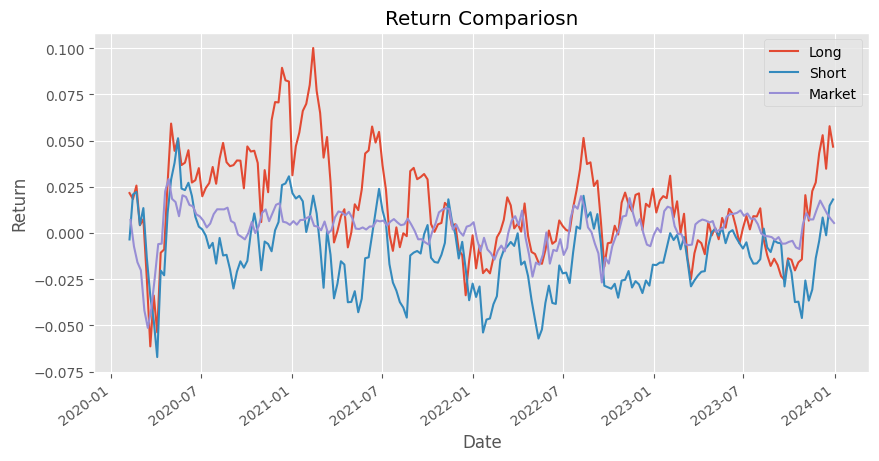

In [119]:
import matplotlib.pyplot as plt

plt.style.use(['ggplot'])

fig, ax = plt.subplots()
# Create a new figure with the desired size
fig.set_size_inches(10, 5)

ax.plot(result_long.date,result_long.ret.rolling(Moving).mean())
ax.plot(result_short.date,result_short.ret.rolling(Moving).mean())
ax.plot(ret_mk_df.Date,ret_mk_df.ret.rolling(Moving).mean())

ax.set(title = "Return Compariosn", xlabel = "Date", ylabel="Return")

# The 'legend' function takes the labels as a list, so you need to provide them as a list
ax.legend(['Long', 'Short', "Market"])
fig.autofmt_xdate(rotation=36)

plt.show()

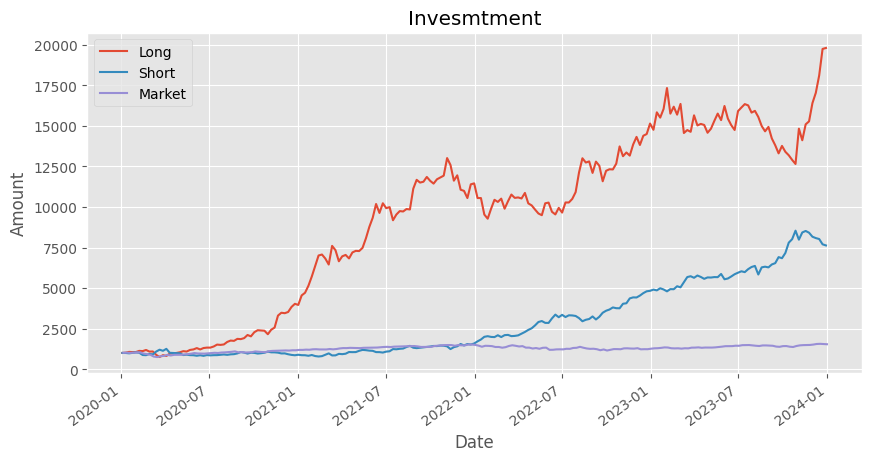

In [120]:
import matplotlib.pyplot as plt

plt.style.use(['ggplot'])

fig, ax = plt.subplots()
# Create a new figure with the desired size
fig.set_size_inches(10, 5)

ax.plot(result_long.date,(result_long.ret + 1).cumprod()*1000)
#ax.plot(result_short.date,(result_short.ret + 1).cumprod()*1000)
ax.plot(result_short.date,(result_short.ret*-1 + 1).cumprod()*1000)

ax.plot(ret_mk_df.Date,(ret_mk_df.ret + 1).cumprod()*1000)

ax.set(title = "Invesmtment", xlabel = "Date", ylabel="Amount")

# The 'legend' function takes the labels as a list, so you need to provide them as a list
ax.legend(['Long', 'Short', "Market"])
fig.autofmt_xdate(rotation=36)

plt.show()

In [121]:
import plotly.graph_objects as go

# Create traces
trace_long = go.Scatter(x=result_long['date'], y=(result_long['ret'] + 1).cumprod() * 1000, name='Long')
trace_short = go.Scatter(x=result_short['date'], y=(result_short['ret'] * -1 + 1).cumprod() * 1000, name='Short')
#trace_short = go.Scatter(x=result_short['date'], y=(result_short['ret'] + 1).cumprod() * 1000, name='Short')
trace_market = go.Scatter(x=ret_mk_df['Date'], y=(ret_mk_df['ret'] + 1).cumprod() * 1000, name='Market')

# Create figure and add traces
fig = go.Figure(data=[trace_long, trace_short, trace_market])

# Update layout
fig.update_layout(
    title='Investment',
    xaxis_title='Date',
    yaxis_title='Amount',
    xaxis=dict(tickangle=36),
    width=1000,
    height=500
)

# Show the plot
fig.show()